In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset
import sys
from scipy.stats.mstats import winsorize
import seaborn as sns

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import plotly_express as px
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from lightgbm import LGBMRegressor

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [2]:
dfe = pd.read_csv("C:\Pablo\datasets\\household_power_consumption.txt", delimiter=";", low_memory=False)

<>:1: DeprecationWarning: invalid escape sequence '\P'


In [3]:
dfe.replace(to_replace='?',value=np.nan,inplace=True)
#dfe.dropna(subset=['Sub_metering_3'],inplace=True)

In [4]:
def flotante(string):
    try:
        return float(string)
    except:
        return float(0)

float_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for col in float_cols:
    dfe[col] = dfe[col].apply(lambda x: flotante(x))

In [5]:
dfe['date_time'] = pd.to_datetime(dfe['Date'] + ' ' + dfe['Time'])
dfe['weekend'] = dfe['date_time'].apply(lambda x: x.weekday() < 5).astype(int)

C:\Users\Pablo\AppData\Local\Temp\ipykernel_11588\973383101.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  dfe['date_time'] = pd.to_datetime(dfe['Date'] + ' ' + dfe['Time'])


In [6]:
from math import *

potencia aparente y factor de potencia

In [7]:
pag = dfe.Global_active_power*1000
prg = dfe.Global_reactive_power*1000
pa = (pag**2)+(prg**2)
pa = pa.apply(lambda x: sqrt(x))
dfe.insert(loc=4,column='apparent_power',value=pa)

pf = (dfe.Global_active_power/(dfe.apparent_power/1000))
dfe.insert(loc=4,column='power_factor',value=pf)

## Outliers

In [8]:
float_cols = ['Global_active_power', 'Global_reactive_power','power_factor','apparent_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

In [9]:
def grafico_de_caja(df,column, title=''):
    n_rows = len(column)
    fig, axes = plt.subplots(nrows=n_rows, figsize=(15, 20))
    fig.tight_layout()

    for i in range(n_rows):
        ax = axes[i]
        sns.boxplot(data=df[column[i]], ax=ax, orient='h')
        ax.set_title(f'{column[i]} {title}', loc="right")
    return plt.show()

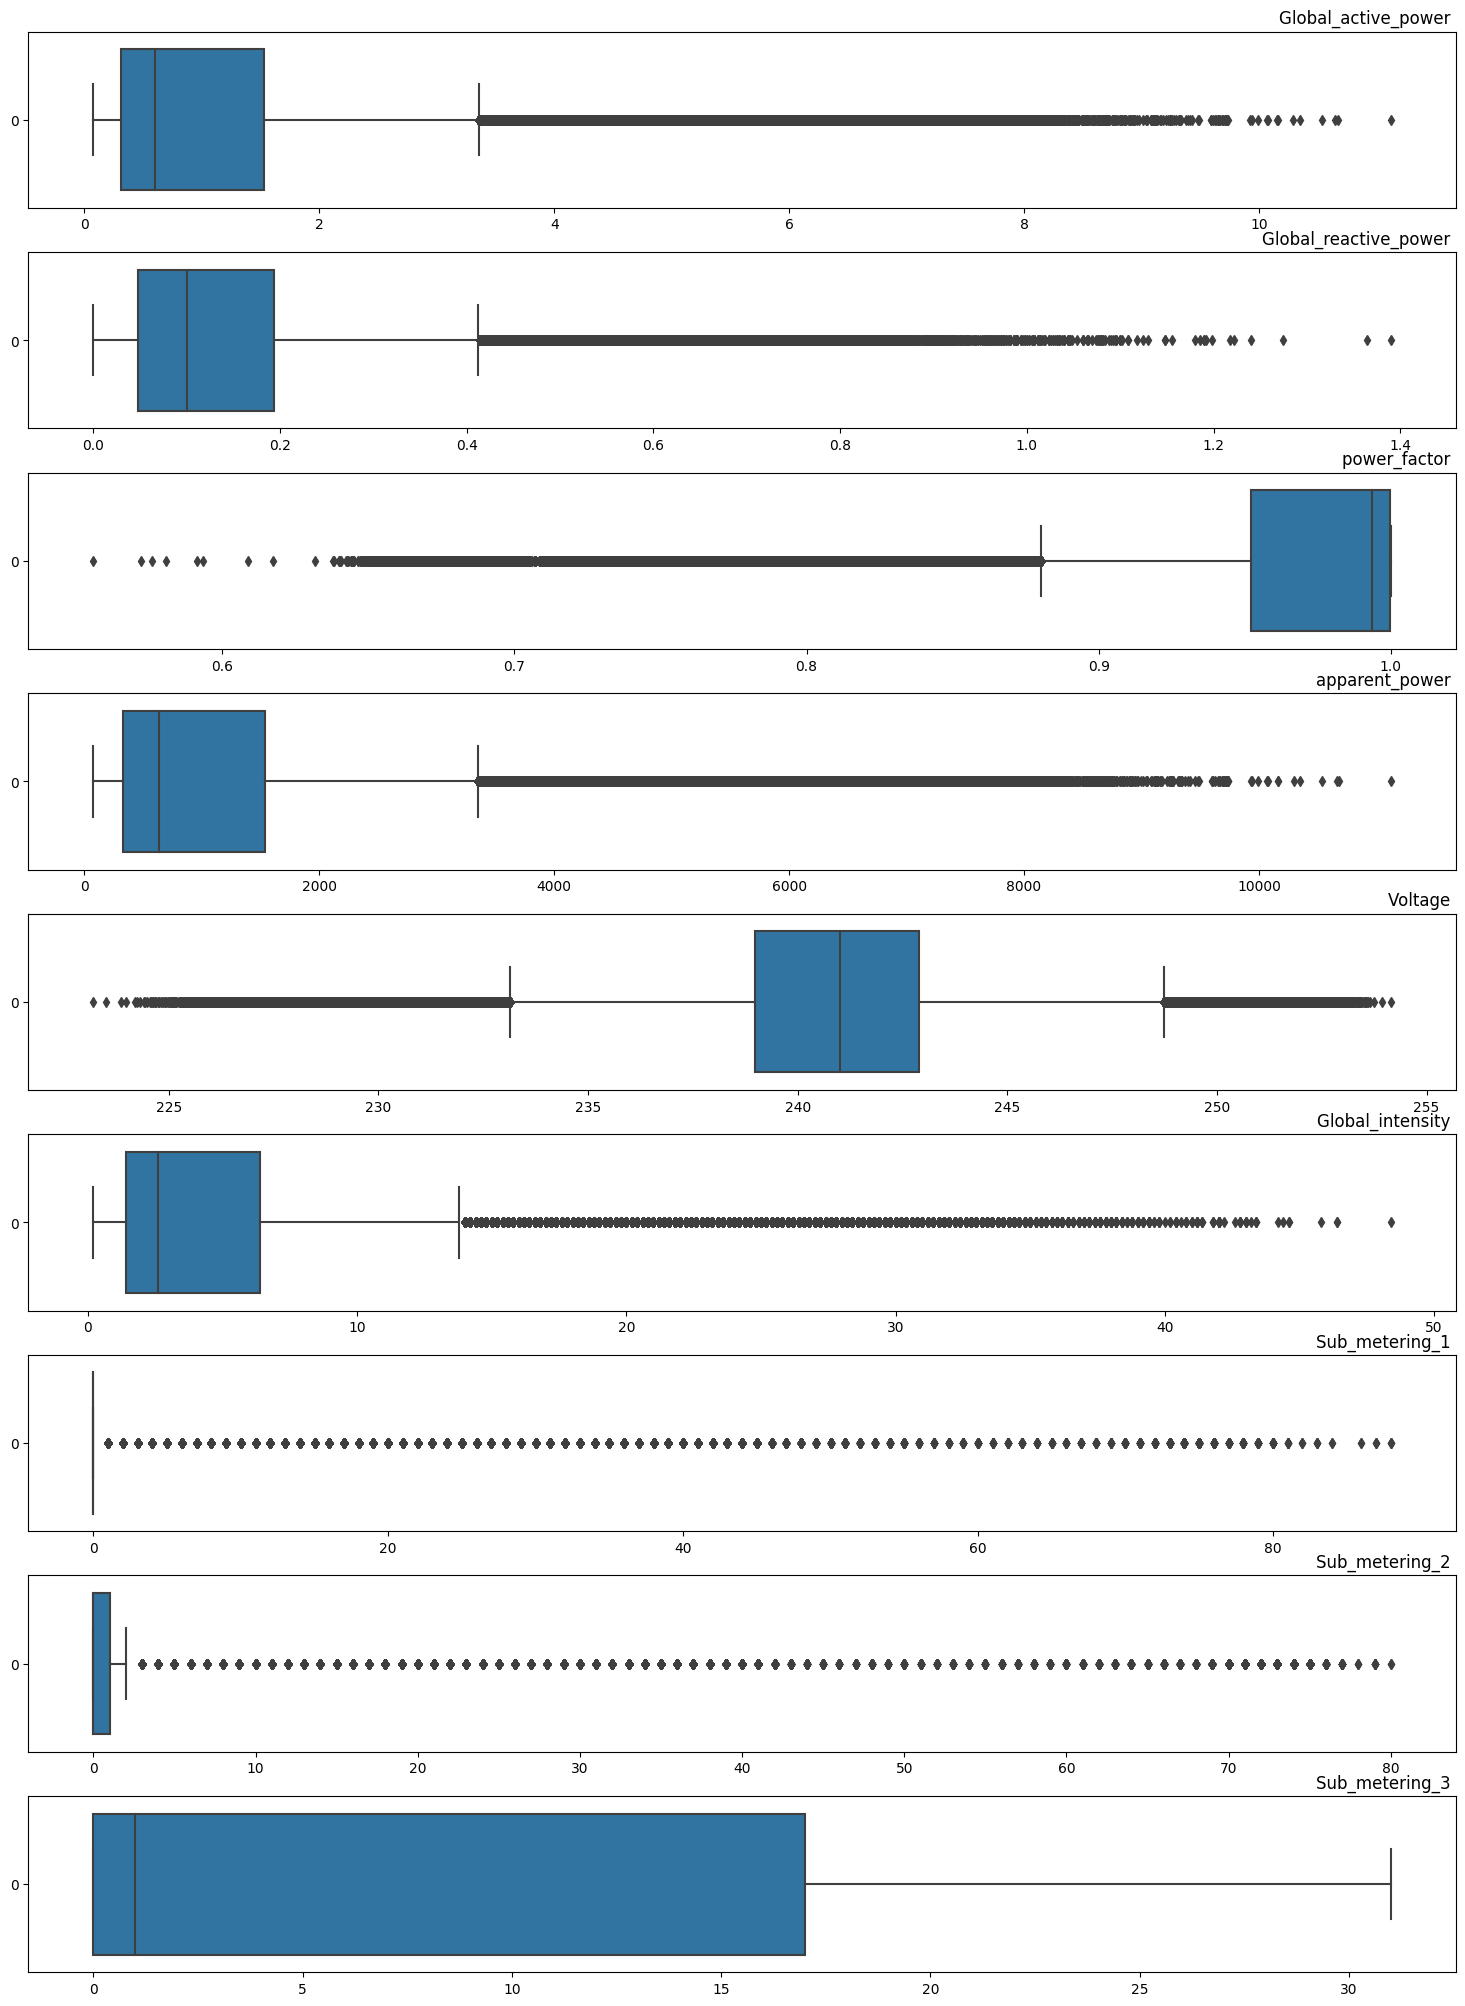

In [10]:
box_plot = grafico_de_caja(dfe,float_cols)

In [11]:
dfe.drop(['Date','Time'],inplace=True,axis=1)
columnas_numericas = [dfe.columns]
columnas_numericas

[Index(['Global_active_power', 'Global_reactive_power', 'power_factor',
        'apparent_power', 'Voltage', 'Global_intensity', 'Sub_metering_1',
        'Sub_metering_2', 'Sub_metering_3', 'date_time', 'weekend'],
       dtype='object')]

In [12]:
def replace_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    column = column.where((column >= lower_bound) & (column <= upper_bound), 
                          other=column.clip(lower=lower_bound, upper=upper_bound))
    return column

La funcion replace_outlier, devuelve la columna a reemplazar en forma de serie.

In [13]:
dfe_h = dfe.resample('H',on='date_time').sum()
#dfe_h = dfe.asfreq('60min')
dfe_h.shape

(34589, 10)

In [14]:
def replace_outliers(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    column = column.where((column >= lower_bound) & (column <= upper_bound), 
                          other=column.clip(lower=lower_bound, upper=upper_bound))
    return column

In [15]:
dfe_h['Global_active_power'] = replace_outliers(dfe_h['Global_active_power'])
dfe_h['Global_reactive_power'] = replace_outliers(dfe_h['Global_reactive_power'])
dfe_h['power_factor'] = replace_outliers(dfe_h['power_factor'])
dfe_h['apparent_power'] = replace_outliers(dfe_h['apparent_power'])
dfe_h['Voltage'] = replace_outliers(dfe_h['Voltage'])
dfe_h['Global_intensity'] = replace_outliers(dfe_h['Global_intensity'])

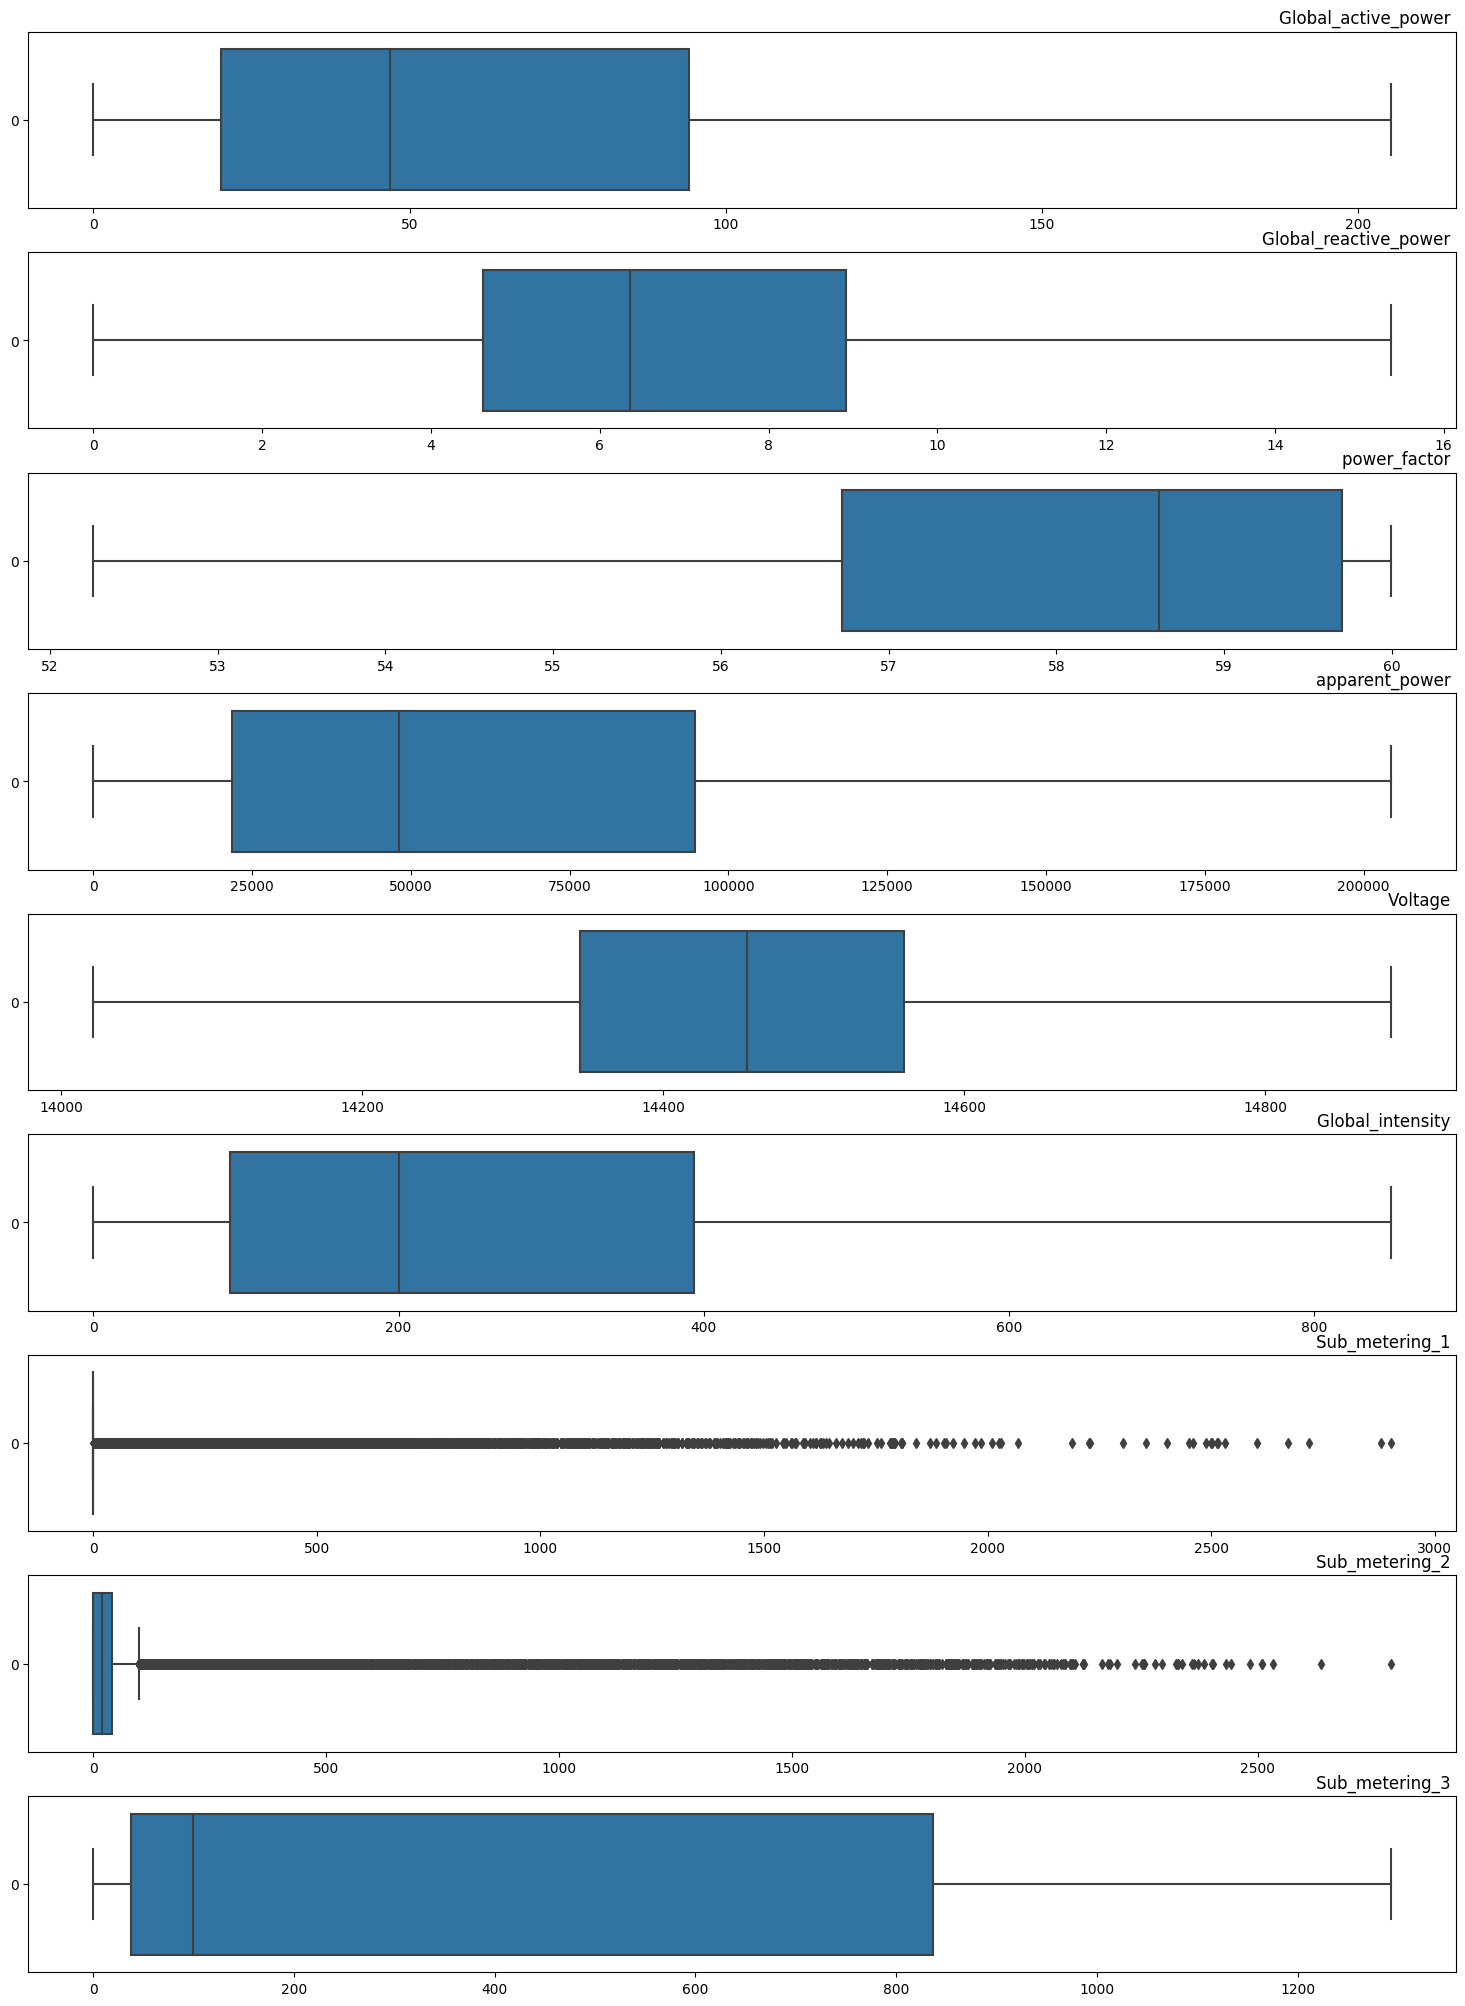

In [16]:
box_plot = grafico_de_caja(dfe_h,float_cols)

In [17]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_val = df[feature_name].max()
        min_val = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_val) / (max_val - min_val)

    return result

In [18]:
dfe_norm = normalize(dfe_h[['Global_active_power','Global_reactive_power','Global_intensity','power_factor','apparent_power','Voltage']])

In [19]:
dfe_h.isna().sum()

Global_active_power      0
Global_reactive_power    0
power_factor             0
apparent_power           0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
weekend                  0
dtype: int64

In [20]:
datos = dfe_norm[['Global_active_power', 'Global_reactive_power','power_factor', 'Voltage']]

In [21]:
datos.shape

(34589, 4)

In [22]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(
                    start = datos.index.min(),
                    end   = datos.index.max(),
                    freq  = datos.index.freq)
).all()

True

## Porcion de los datos
- Conjunto de entrenamiento
- conjunto de validacion
- conjunto de test

La razon de la existencia del conjunto de validacion es que, el proceso de busqueda de los mejores hiperparametros, no debe hacerse sobre los datos de test, ya que se podria estar cayendo en sobreajuste del modelo.

In [23]:
datos = datos.loc['2007-01-01 17:24:00':'2009-06-01 00:00:00']
fin_train = '2009-02-28 00:00:00'
fin_validacion = '2009-05-01 00:00:00'

In [24]:
datos_train = datos.loc[:fin_train,:] # 2 años y 3 meses
datos_val = datos.loc[fin_train:fin_validacion,:] # 2 meses (Diferencia entre el final de los datos de train y la validacion)
datos_test = datos.loc[fin_validacion:,:] # 1 meses (fin de validacion a final de los datos)

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")


Fechas train : 2007-01-01 18:00:00 --- 2009-02-28 00:00:00  (n=18919)
Fechas validacion : 2009-02-28 00:00:00 --- 2009-05-01 00:00:00  (n=1489)
Fechas test : 2009-05-01 00:00:00 --- 2009-06-01 00:00:00  (n=745)


## Visualizacion
grafico de la potencia o energia activa


In [25]:
"""
fig, ax = plt.subplots(figsize=(15,4))
datos_train.Global_active_power.plot(ax=ax, label='Entrenamiento',linewidth=1)
datos_val.Global_active_power.plot(ax=ax, label='Validacion',linewidth=1)
datos_test.Global_active_power.plot(ax=ax, label='Test',linewidth=1)
ax.set_title('Energia activa')
ax.legend()
"""

"\nfig, ax = plt.subplots(figsize=(15,4))\ndatos_train.Global_active_power.plot(ax=ax, label='Entrenamiento',linewidth=1)\ndatos_val.Global_active_power.plot(ax=ax, label='Validacion',linewidth=1)\ndatos_test.Global_active_power.plot(ax=ax, label='Test',linewidth=1)\nax.set_title('Energia activa')\nax.legend()\n"

## Grafico interactivo

In [26]:
datos.loc[:fin_train,'partition'] = 'train'
datos.loc[fin_train:fin_validacion,'partition'] = 'validation'
datos.loc[fin_validacion:,'partition'] = 'test'

fig = px.line(
    data_frame=datos.reset_index(),
    x = 'date_time',
    y = 'Global_active_power',
    color = 'partition',
    title = 'Number of users',
    width = 1200,
    height= 700
)
fig.show()
datos = datos.drop(columns='partition')

## Autocorrelacion
Tenes en consideracion, que al eliminar datos nulos, se pierde la continuidad temporal del dataset, lo que genera no poder visualizar la autocorrelacion del metodo acf(autocorrelación), para poder evitar esto se puede:
1- analizar el periodo de tiempo donde se encuentran los valores nulos y obviarlo(no usar ese periodo)
2- analizar el periodo de tiempo y continuarlo, rellenandolo con el metodo mean, forward fill o backward fill.
3- analizar el periodo de tiempo y cortarlo o dropearlo, usando otra manera de visualizar la autocorrelacion.

La autocorrelación (ACF) y la autocorrelación parcial (PACF) son medidas de asociación entre valores de serie actuales y pasadas e indican cuáles son los valores de series pasadas más útiles para predecir valores futuros.

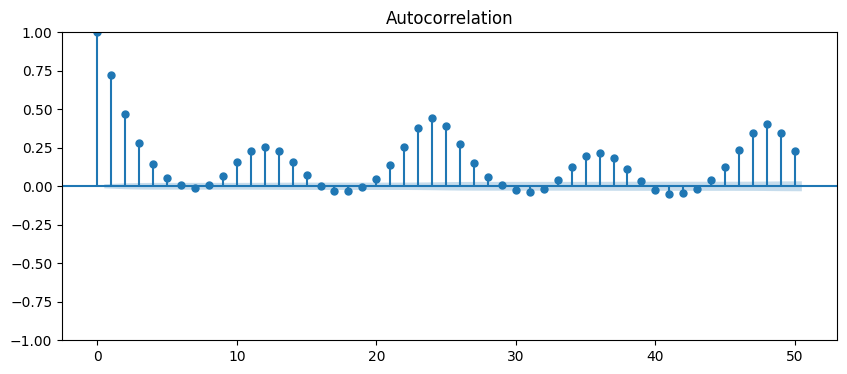

In [27]:
fig, ax = plt.subplots(figsize=(10,4))
plot_acf(datos.Global_active_power, ax= ax, lags=50)
plt.show()

Con el grafico de autocorrelacion, podemos observar que existe cierta correlacion, que aumenta con cierta frecuencia teniendo en cuenta que cada lag representado en el grafico corresponde a 1h

nota: tanto los graficos como los metodos plot_acf y plot_pacf tardan demasiado con instancias por minuto del dataset.
el metodo de autocorrelacion es mucho mas lento que el de autocorrelacion parcial

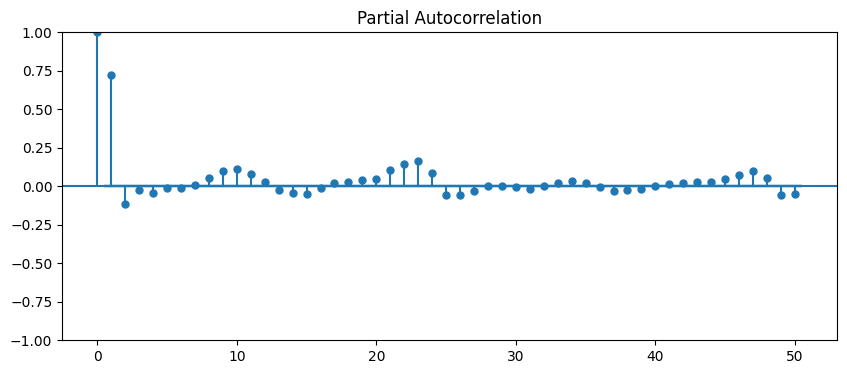

In [28]:
fig, ax = plt.subplots(figsize=(10,4))
plot_pacf(datos.Global_active_power, ax= ax, lags=50)
plt.show()

## Modelacion
- Crear el objeto forecaster(autoregresivo)
- Asignar el regresor, el modelo de alguna libreria de machine learning, en este caso LGBMRegressor(grading boosting).
- Se le asigna la profundidad maxima, la taza de aprendizaje, la cantidad de arboles que formen el modelo y la cantidad de lags que quiero implementar


In [29]:
#Forecaster
forecaster = ForecasterAutoreg(
    regressor= LGBMRegressor(max_depth=2,learning_rate=0.1,n_estimators=50),
    lags = 24
)
forecaster # forecaster.summary

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2024-04-06 08:59:23 
Last fit date: None 
Skforecast version: 0.11.0 

In [30]:
forecaster.fit(y=datos.loc[:fin_validacion,'Global_active_power'])
forecaster

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 20383, number of used features: 24
[LightGBM] [Info] Start training from score 0.320372


ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: None 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2007-01-01 18:00:00'), Timestamp('2009-05-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date:

In [31]:
predicciones = forecaster.predict(steps=24)
predicciones

2009-05-01 01:00:00    0.373506
2009-05-01 02:00:00    0.275834
2009-05-01 03:00:00    0.231723
2009-05-01 04:00:00    0.213644
2009-05-01 05:00:00    0.241410
2009-05-01 06:00:00    0.333842
2009-05-01 07:00:00    0.442171
2009-05-01 08:00:00    0.496787
2009-05-01 09:00:00    0.487984
2009-05-01 10:00:00    0.482251
2009-05-01 11:00:00    0.464795
2009-05-01 12:00:00    0.449245
2009-05-01 13:00:00    0.435793
2009-05-01 14:00:00    0.389762
2009-05-01 15:00:00    0.313176
2009-05-01 16:00:00    0.289115
2009-05-01 17:00:00    0.344867
2009-05-01 18:00:00    0.390864
2009-05-01 19:00:00    0.366737
2009-05-01 20:00:00    0.359555
2009-05-01 21:00:00    0.408175
2009-05-01 22:00:00    0.484580
2009-05-01 23:00:00    0.511964
2009-05-02 00:00:00    0.461609
Freq: H, Name: pred, dtype: float64

**Prediccion de un tiempo determinado con grafico interactivo**

In [32]:
datos_plot = pd.DataFrame({
    'test': datos_test['Global_active_power'],
    'prediccion':predicciones,
})
datos_plot.index.name = 'date_time'
fig = px.line(
    data_frame=datos_plot.reset_index(),
    x = 'date_time',
    y = datos_plot.columns,
    title = 'Cantidad de energia activa en kWh',
    width=1200,
    height= 500
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Backtesting
El backtesting es una técnica para evaluar el rendimiento de un modelo de pronóstico utilizando datos históricos.
Para simular un pronostico a lo largo de la serie hacemos uso de la tecnica de backtesting.

- funcion backtesting
Parametros:
- modelo
- datos
- tamaño inicial
- metrica

In [33]:
metrica, predicciones = backtesting_forecaster(
    forecaster= forecaster,
    y = datos['Global_active_power'],
    initial_train_size= len(datos.loc[:fin_validacion]),
    steps = 24,
    metric = 'mean_absolute_error',
    refit = False,
    verbose= True
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 20383, number of used features: 24
[LightGBM] [Info] Start training from score 0.320372
Information of backtesting process
----------------------------------
Number of observations used for initial training: 20407
Number of observations used for backtesting: 744
    Number of folds: 31
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2007-01-01 18:00:00 -- 2009-05-01 00:00:00  (n=20407)
    Validation: 2009-05-01 01:00:00 -- 2009-05-02 00:00:00  (n=24)
Fold: 1
    Training:   2007-01-01 18:00:00 -- 2009-05-01 00:00:00  (n=20407)
    Validation: 2009-05-02 01:00:00 -- 2009-05-03 00:00:00  (n=24)
Fold: 2
    Training:   2007-01-01 18:00:00 -- 2009-

  0%|          | 0/31 [00:00<?, ?it/s]

In [34]:
print('backstest error: ', {metrica})

backstest error:  {0.1498359962788501}


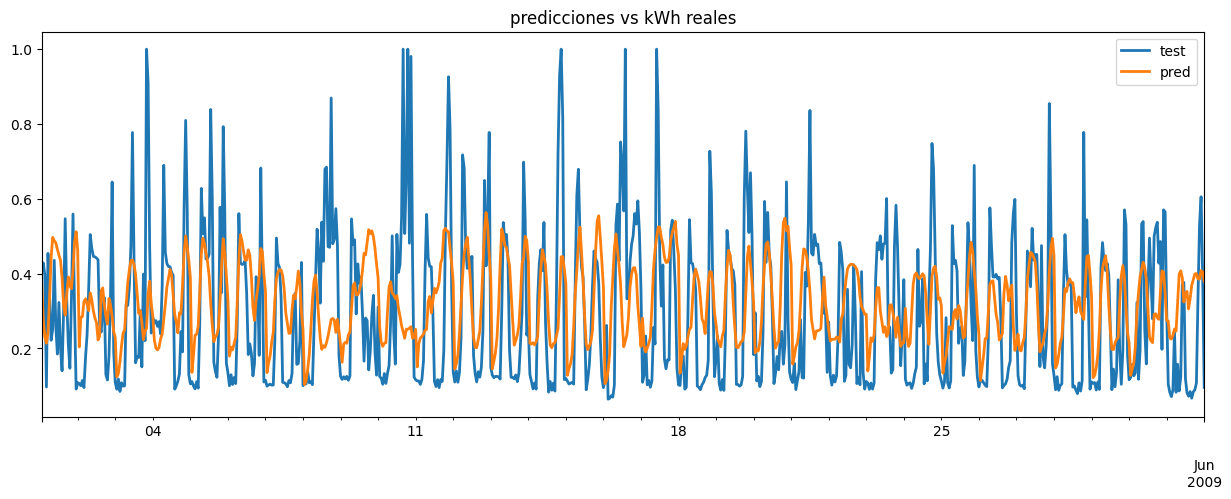

In [35]:
fig, ax = plt.subplots(figsize=(15,5))
datos.loc[predicciones.index,'Global_active_power'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2, label='Prediccion',ax=ax)
ax.set_title('predicciones vs kWh reales')
ax.legend()

## Storytelling
Como se ve a simple vista, el modelo intenta parecerse, pero no logra llegar, en algunos casos podria decirse que:
- Capta su estructura, patron o comportamiento pero no la magnitud de las observaciones.
- No capta su estructura y tampoco su magnitud
- Los valores atipicos generan mayor ruido en la serie.

In [36]:
# grafico interactivo
datos_plot = pd.DataFrame({
    'test': datos_test['Global_active_power'],
    'prediccion':predicciones['pred'],
})
datos_plot.index.name = 'date_time'

fig = px.line(
    data_frame=datos_plot.reset_index(),
    x = 'date_time',
    y = datos_plot.columns,
    title = 'Cantidad de energia activa en kWh',
    width=1200,
    height= 500
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Backtesting con intervalos

In [37]:
metrica, predicciones = backtesting_forecaster(
    forecaster= forecaster,
    y = datos['Global_active_power'],
    initial_train_size= len(datos.loc[:fin_validacion]),
    steps = 24,
    interval= [5,95], # intervalo del 90% 
    n_boot= 100,
    metric = 'mean_absolute_error',
    refit = False,
    verbose= True
)
predicciones.head()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6120
[LightGBM] [Info] Number of data points in the train set: 20383, number of used features: 24
[LightGBM] [Info] Start training from score 0.320372
Information of backtesting process
----------------------------------
Number of observations used for initial training: 20407
Number of observations used for backtesting: 744
    Number of folds: 31
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2007-01-01 18:00:00 -- 2009-05-01 00:00:00  (n=20407)
    Validation: 2009-05-01 01:00:00 -- 2009-05-02 00:00:00  (n=24)
Fold: 1
    Training:   2007-01-01 18:00:00 -- 2009-05-01 00:00:00  (n=20407)
    Validation: 2009-05-02 01:00:00 -- 2009-05-03 00:00:00  (n=24)
Fold: 2
    Training:   2007-01-01 18:00:00 -- 2009-

  0%|          | 0/31 [00:00<?, ?it/s]

,pred,lower_bound,upper_bound
2009-05-01 01:00:00,0.373506,0.145500,0.663888
2009-05-01 02:00:00,0.275834,0.016676,0.580370
2009-05-01 03:00:00,0.231723,-0.041614,0.653594
2009-05-01 04:00:00,0.213644,-0.076853,0.624714
2009-05-01 05:00:00,0.241410,-0.008223,0.613672


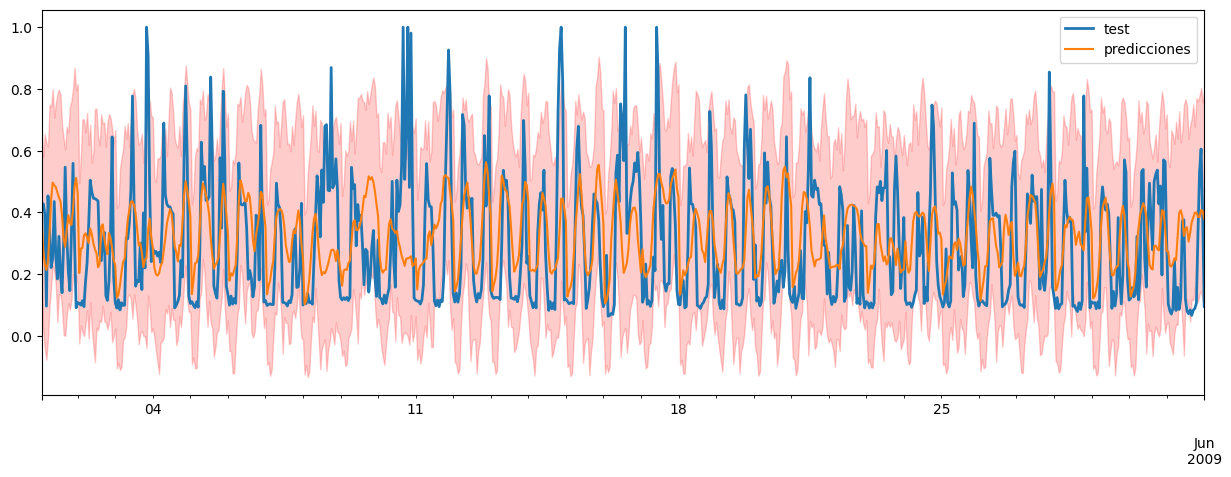

In [38]:
# Grafico
fig, ax = plt.subplots(figsize=(15,5))
datos.loc[predicciones.index,'Global_active_power'].plot(ax=ax,linewidth=2,label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color='red',
    alpha= 0.2
)
ax.legend()

## Uso del grid_search_forecaster
Con esta herramienta podemos concluir cuales son los mejores hiperparametros del grid.

In [ ]:
#grid search de hiperparametros
#hiperparametros del regresor
param_grid = {
    'max_iter':[100,500], # numero de arboles que forman parte del modelo de gradint boosting
    'max_depth':[3,10], # Profundidad maxima del arbol
    'learning_rate':[0.01,0.1]
}
#lags utilizados como predictores
lags_grid = [24,48,[1,2,24]]

resultados_grid = grid_search_forecaster(
    forecaster= forecaster,
    y = datos.loc[:fin_validacion,'Global_active_power'], # conjunto de train + validacion
    param_grid = param_grid,
    lags_grid= lags_grid,
    steps = 24,
    refit = False,
    metric = 'mean_absolute_error',
    initial_train_size= int(len(datos_train)), # el modelo se entrena con los datos de entrenamiento
    return_best= True,
    verbose = False,
    show_progress=True
)

In [40]:
resultados_grid.head(10)

,lags,params,mean_absolute_error,learning_rate,max_depth,max_iter
15,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",0.146552,0.10,10.0,500.0
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'max_...",0.147558,0.01,10.0,500.0
14,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",0.147992,0.10,10.0,100.0
13,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",0.148941,0.10,3.0,500.0
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",0.149197,0.10,10.0,100.0
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",0.150064,0.10,3.0,100.0
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 10, 'max_i...",0.151273,0.10,10.0,500.0
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 3, 'max_i...",0.152285,0.01,3.0,500.0
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.1, 'max_depth': 3, 'max_it...",0.152846,0.10,3.0,500.0
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'learning_rate': 0.01, 'max_depth': 10, 'max_...",0.152930,0.01,10.0,500.0


## Mejora del modelo con los mejores hiperparametros

In [41]:
metrica, predicciones = backtesting_forecaster(
    forecaster= forecaster,
    y = datos.Global_active_power,
    initial_train_size= len(datos.loc[:fin_validacion]),
    steps = 24,
    metric = 'mean_absolute_error',
    refit = False,
    verbose= False
)
print(f"backtest error: ",{metrica})

c:\Users\Pablo\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning:

Found `max_iter` in params. Will use it instead of argument



[LightGBM] [Warning] num_iterations is set=500, max_iter=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 20359, number of used features: 48
[LightGBM] [Info] Start training from score 0.320451


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^m

In [42]:
forecaster = ForecasterAutoreg(
    regressor= LGBMRegressor(max_depth=3,learning_rate=0.1,n_estimators=100),
    lags = 48
)
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
fit_kwargs: {} 
Creation date: 2024-04-06 0

# Entrenar el modelo con variables exogenas

Se debe pasar los datos de "y" de respuesta y los datos de respuesta de las variables exogenas

In [43]:
variables_exog = ['Global_reactive_power','power_factor','Voltage']

forecaster.fit(
    y = datos.loc[:fin_validacion, 'Global_active_power'],
    exog = datos.loc[:fin_validacion,variables_exog]
)
forecaster

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 20359, number of used features: 51
[LightGBM] [Info] Start training from score 0.320451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Global_reactive_power', 'power_factor', 'Voltage'] 
Training range: [Timestamp('2007-01-01 18:00:00'), Timestamp('2009-05-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None,

In [44]:
# prediccion
exog_siguientes_24h = datos_test[variables_exog][1:25]
# NOTA: Para que la variable "exog" este un paso adelante para poder realizar las predicciones,
# la variable exog_siguientes_24h, se le pasa como indice, las variables y el comienzo de los datos apartir de 1.
predicciones = forecaster.predict(steps=24,exog=exog_siguientes_24h)
predicciones

2009-05-01 01:00:00    0.446673
2009-05-01 02:00:00    0.454313
2009-05-01 03:00:00    0.406952
2009-05-01 04:00:00    0.135818
2009-05-01 05:00:00    0.472336
2009-05-01 06:00:00    0.315531
2009-05-01 07:00:00    0.328438
2009-05-01 08:00:00    0.252285
2009-05-01 09:00:00    0.489169
2009-05-01 10:00:00    0.318809
2009-05-01 11:00:00    0.229650
2009-05-01 12:00:00    0.431301
2009-05-01 13:00:00    0.311557
2009-05-01 14:00:00    0.169544
2009-05-01 15:00:00    0.233367
2009-05-01 16:00:00    0.589307
2009-05-01 17:00:00    0.432740
2009-05-01 18:00:00    0.303846
2009-05-01 19:00:00    0.173541
2009-05-01 20:00:00    0.287826
2009-05-01 21:00:00    0.475653
2009-05-01 22:00:00    0.239499
2009-05-01 23:00:00    0.092853
2009-05-02 00:00:00    0.118288
Freq: H, Name: pred, dtype: float64

# Backtesting con mejores hiperparametros y variables exogenas

In [45]:
metrica, predicciones = backtesting_forecaster(
    forecaster= forecaster,
    y = datos['Global_active_power'],
    exog = datos[variables_exog],
    initial_train_size= len(datos.loc[:fin_validacion]),
    steps = 24,
    metric = 'mean_absolute_error',
    refit = False,
    verbose= False
)
metrica

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13005
[LightGBM] [Info] Number of data points in the train set: 20359, number of used features: 51
[LightGBM] [Info] Start training from score 0.320451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


  0%|          | 0/31 [00:00<?, ?it/s]

0.05349972981759826

El valor de la metrica sin normalizacion se mejoro a desde 30 a 11(mean_absolute_error)

El valor de la metrica con normalizacion se mejoro a desde 0,15 a 0,05 

## Grafico con mejores hiperparametros

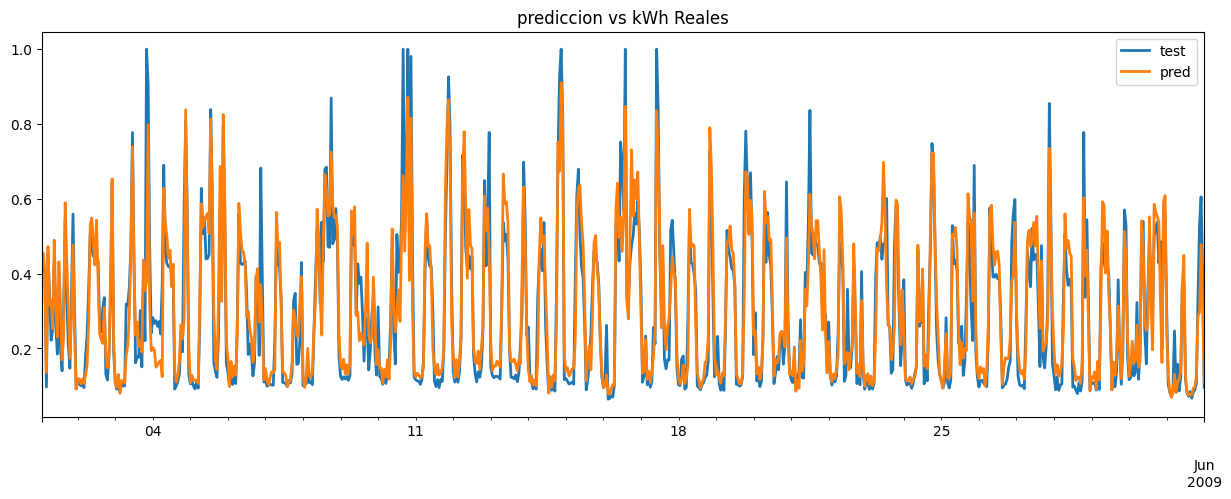

In [46]:
#grafico

fig, ax = plt.subplots(figsize=(15,5))
datos.loc[predicciones.index,'Global_active_power'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2,label='prediccion',ax=ax)
ax.set_title('prediccion vs kWh Reales')
ax.legend()

importancia de predictores

In [47]:
forecaster.get_feature_importances().sort_values('importance',ascending=False)

,feature,importance
49,power_factor,258
48,Global_reactive_power,178
0,lag_1,63
50,Voltage,35
1,lag_2,24
10,lag_11,11
22,lag_23,11
33,lag_34,9
2,lag_3,8
9,lag_10,8


## Modelo en produccion

In [48]:
forecaster.fit(y=datos.loc[:fin_validacion,'Global_active_power'])
forecaster

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12240
[LightGBM] [Info] Number of data points in the train set: 20359, number of used features: 48
[LightGBM] [Info] Start training from score 0.320451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=3) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48] 
Transformer for y: None 
Transformer for exog: None 
Window size: 48 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2007-01-01 18:00:00'), Timestamp('2009-05-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200

# Predicciones seguidas de los datos utilizados para entrenar el modelo
La ultima fecha que el forecaster utilizo en el entrenamiento es del '2009-05-01 00:00:00', cuando llamemos al metodo predict, por defecto comenzara apartir de esta fecha.

In [49]:
predicciones = forecaster.predict(steps=24)
predicciones.head()

2009-05-01 01:00:00    0.319410
2009-05-01 02:00:00    0.223177
2009-05-01 03:00:00    0.177940
2009-05-01 04:00:00    0.188631
2009-05-01 05:00:00    0.233034
Freq: H, Name: pred, dtype: float64

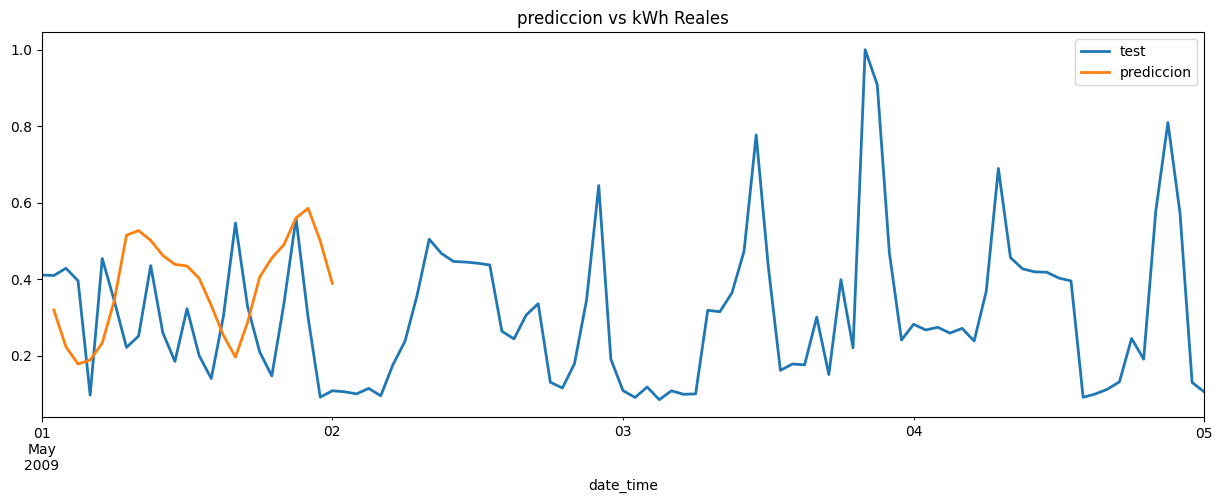

In [50]:
#grafico

fig, ax = plt.subplots(figsize=(15,5))
datos_test.loc[:'2009-05-05 00:00:00','Global_active_power'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2,label='prediccion',ax=ax)
ax.set_title('prediccion vs kWh Reales')
ax.legend()

# predicciones en un instante determinado de tiempo

In [51]:
datos_ultimos_72h = datos.loc['2009-05-02 01:00:00':'2009-05-05 01:00:00','Global_active_power']
predicciones = forecaster.predict(steps=24,last_window = datos_ultimos_72h)
predicciones.head()

2009-05-05 02:00:00    0.147982
2009-05-05 03:00:00    0.166928
2009-05-05 04:00:00    0.172416
2009-05-05 05:00:00    0.223947
2009-05-05 06:00:00    0.336650
Freq: H, Name: pred, dtype: float64

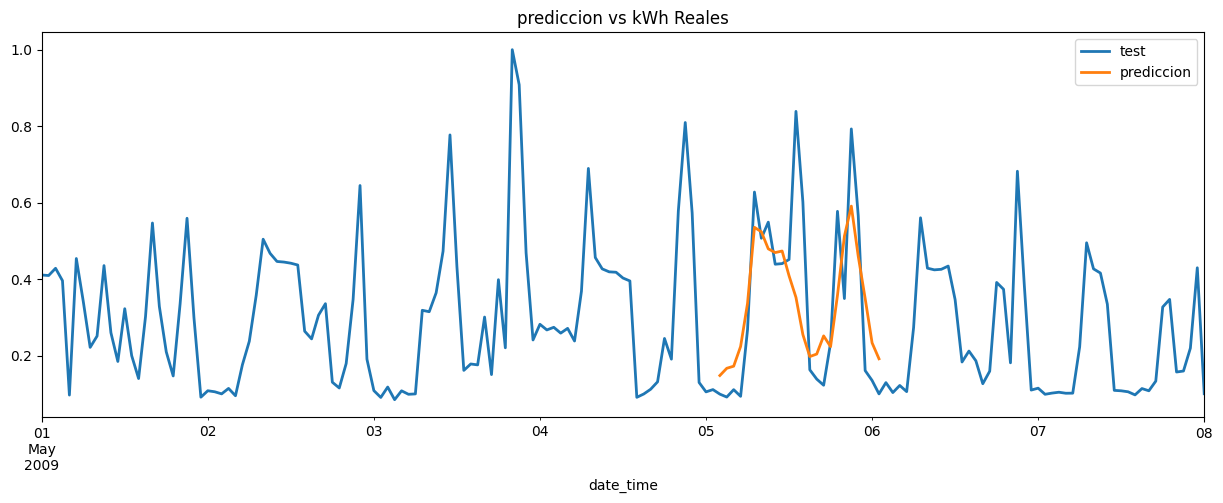

In [52]:
fig, ax = plt.subplots(figsize=(15,5))
datos_test.loc[:'2009-05-08 00:00:00','Global_active_power'].plot(ax=ax,linewidth=2,label='test')
predicciones.plot(linewidth=2,label='prediccion',ax=ax)
ax.set_title('prediccion vs kWh Reales')
ax.legend()